In [82]:
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
import re
import spacy
from gensim.corpora.dictionary import Dictionary
from gensim.models import LdaModel
from gensim.models.coherencemodel import CoherenceModel
from tqdm.auto import tqdm
import geopandas as gpd
import contextily as ctx


In [1]:
import pandas as pd

## Loading the data

In [2]:
df = pd.read_csv('nl_full_all_columns.csv')
df.head()

Unnamed: 0   id           title  type region   latitude  longitude  \
0           0   72          Arnhem  city     NL  51.983333   5.916667   
1           1  112      Amersfoort  city     NL  52.156389   5.389722   
2           2  227  Bergen op Zoom  city     NL  51.500000   4.300000   
3           3  345        Dorestad  city     NL  51.975000   5.340000   
4           4  371         Drenthe   NaN     NL  52.916667   6.583333   

                                          clean_text  geohash country_code  \
0  Arnhem (uitspraak:  of , Arnhems: Ernem) is ee...  u1hpwxk           NL   
1  Amersfoort () is een stad en gemeente in het o...  u17bdwu           NL   
2  Bergen op Zoom (; Bergs: Bèrrege, Frans: Berg-...  u15hcz7           NL   
3  Dorestad was in de middeleeuwen een belangrijk...  u15z9tb           NL   
4  Drenthe (oude spelling van vóór 2006: Drente (...  u1ktjc1           NL   

                                      thumbnail_link  \
0  https://upload.wikimedia.org/wikipedia/commons...   
1  https://upload.wikimedia.org/wikipedia/commons...   
2                                                NaN   
3  https://upload.wikimedia.org/wikipedia/commons...   
4  https://upload.wikimedia.org/wikipedia/commons...   

           thumbnail_file_name  \
0  23_april_2016_CS_Arnhem.jpg   
1        Koppelpoort_Night.jpg   
2                          NaN   
3            Frisia_716-la.svg   
4          Flag_of_Drenthe.svg   

                                    thumbnail_author thumbnail_license  \
0                                       Hellendijk81      CC BY-SA 4.0   
1                                       Richywiseman      CC BY-SA 4.0   
2                                                NaN               NaN   
3  Frankish_Empire_481_to_814-fr.svg: Sémhur, Eri...      CC BY-SA 3.0   
4                                                NaN     Public domain   

  thumbnail_file_extension                                     generated_text  \
0                      jpg  Arnhem, the capital of Gelderland, is a city w...   
1                      jpg  Amersfoort, nestled in the eastern part of the...   
2                      NaN  Bergen op Zoom is a city in the westernmost pa...   
3                      svg  Dorestad: A Thriving Medieval Trading Post\n\n...   
4                      svg  Drenthe, a province in the north of the Nether...   

                      category_output  level main_category      subcategories  
0      [1, city, [region, history]]\n    1.0          city    region, history  
1    [1, city, [history, monument]]\n    1.0          city  history, monument  
2      [1, city, [region, history]]\n    1.0          city    region, history  
3    [2, village, [history, river]]\n    2.0       village     history, river  
4  [1, province, [region, history]]\n    1.0      province    region, history

In [3]:
df.shape

(40107, 20)

## Map of the locations

In [24]:
# Approximate bounding box for the Netherlands
min_lon, max_lon = 3.2, 7.3
min_lat, max_lat = 50.7, 53.7

fig = plt.figure(figsize=(8, 8))
ax = plt.axes(projection=ccrs.Mercator())
ax.set_extent([min_lon, max_lon, min_lat, max_lat], ccrs.PlateCarree())

# Add features
ax.add_feature(cfeature.LAND, edgecolor='black')
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')

# Plot points with small size & transparency
ax.scatter(
    df['longitude'], df['latitude'],
    color='red', s=3,  # smaller size
    alpha=0.2,         # semi-transparent
    transform=ccrs.PlateCarree(),
    label='Locations'
)

plt.title('Locations in the Netherlands')
plt.legend()
plt.show()

## Value overviews

In [5]:
df['main_category'].value_counts().head(20)

main_category
village          6974
monument         5434
church           3824
bridge           2409
neighbourhood    2350
sport            2239
building         2183
house            1597
street           1521
park             1366
station          1222
statue           1104
region            869
museum            849
story             550
square            546
nature            530
canal             522
city              400
water             395
Name: count, dtype: int64

In [7]:
df['level'].value_counts()

level
2.0    23898
3.0    12628
1.0     2345
4.0     1235
Name: count, dtype: int64

There seems to be bias toward level 2 of the locations. Might have to reevaluate that level ranking.

In [9]:
df['subcategories'].value_counts().head(15)

subcategories
nature, story                 2315
building, story               1057
story, trivia                 1056
region, story                  957
story, building                900
monument, story                743
venue, story                   699
unique architecture, story     669
region, history                659
sport, story                   648
building, history              639
story, history                 625
city, story                    587
monument, history              552
monument, art                  506
Name: count, dtype: int64

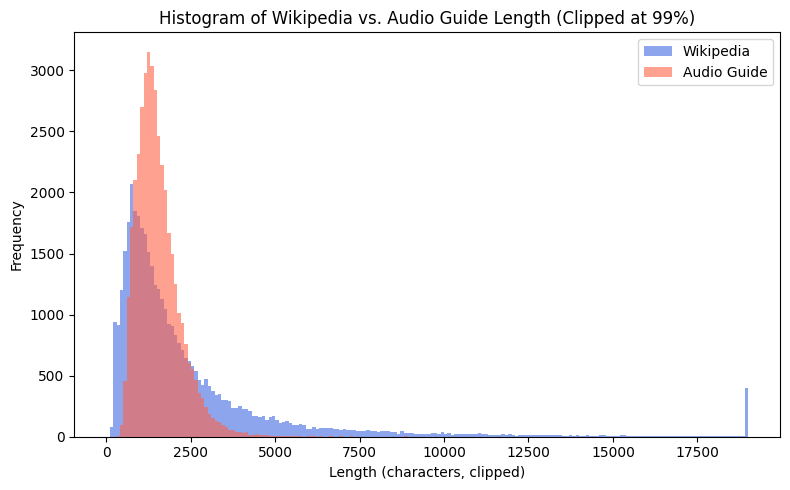

In [17]:
# Drop rows where either field is missing
df_clean = df.dropna(subset=['clean_text', 'generated_text'])

# Calculate lengths
df_clean['wiki_len'] = df_clean['clean_text'].apply(lambda x: len(str(x)))
df_clean['audio_len'] = df_clean['generated_text'].apply(lambda x: len(str(x)))

# Define a cutoff (e.g. 99th percentile) for both
cutoff_wiki = df_clean['wiki_len'].quantile(0.99)
cutoff_audio = df_clean['audio_len'].quantile(0.99)
max_cutoff = int(max(cutoff_wiki, cutoff_audio))

# Create bin edges (e.g., from 0 up to max cutoff, step by 100)
bins = np.arange(0, max_cutoff + 100, 100)

# Plot
plt.figure(figsize=(8,5))
plt.hist(
    df_clean['wiki_len'].clip(upper=max_cutoff), 
    bins=bins, 
    alpha=0.6, 
    color='royalblue', 
    label='Wikipedia'
)
plt.hist(
    df_clean['audio_len'].clip(upper=max_cutoff), 
    bins=bins, 
    alpha=0.6, 
    color='tomato', 
    label='Audio Guide'
)
plt.xlabel('Length (characters, clipped)')
plt.ylabel('Frequency')
plt.title('Histogram of Wikipedia vs. Audio Guide Length (Clipped at 99%)')
plt.legend()
plt.tight_layout()
plt.show()



## Topic modeling

### Latent Dirichlet Allocation (LDA)

First let's make the tokens necessary and preprocess


In [29]:
nlp = spacy.load("en_core_web_sm")

texts = df["generated_text"].dropna().astype(str).tolist()

# Process texts in parallel with a progress bar
processed_docs = nlp.pipe(texts, n_process=10, batch_size=500)
processed_texts = []

#with a progress bar cause I am impatient; inefficient but it is ok as it is one time run
for doc in tqdm(processed_docs, total=len(texts), desc="Processing texts with spaCy"):
    # Lemmatize, remove stopwords, keep only alphabetic tokens, lowercase
    tokens = [token.lemma_.lower() for token in doc
              if not token.is_stop and token.is_alpha]
    processed_texts.append(tokens)

# Assign token lists back to the DataFrame
df["tokens"] = processed_texts

Processing texts with spaCy:   0%|          | 0/40107 [00:00<?, ?it/s]

In [ ]:
#progress save
#df.to_csv("csv_saves/df_tokens.csv")

In [37]:
dictionary = Dictionary(df["tokens"])
bow_corpus = [dictionary.doc2bow(tokens) for tokens in df["tokens"]]

# Define range of topics to evaluate
topics_range = [5, 8, 10, 15, 20, 30]

# Prepare storage for results
results = []

# Loop over different topic counts
for num_topics in tqdm(topics_range, desc="Evaluating LDA Models"):
    # Train the LDA model
    lda_model = LdaModel(
        corpus=bow_corpus,
        id2word=dictionary,
        num_topics=num_topics,
        alpha='auto',
        eta='auto',
        passes=5,  \
        random_state=42
    )

    # Compute perplexity
    perplexity = lda_model.log_perplexity(bow_corpus)

    # Compute coherence score
    coherence_model = CoherenceModel(
        model=lda_model,
        texts=df["tokens"],
        dictionary=dictionary,
        coherence='c_v'  # Use 'c_v' for interpretable coherence
    )
    coherence_score = coherence_model.get_coherence()

    # Store results
    results.append((num_topics, perplexity, coherence_score))
    print(f"Num Topics: {num_topics}, Perplexity: {perplexity}, Coherence: {coherence_score}")

# Display final results
print("\nTopic Count vs. Perplexity & Coherence:")
for num_topics, perplexity, coherence in results:
    print(f"{num_topics} topics: Perplexity = {perplexity:.4f}, Coherence = {coherence:.4f}")

Evaluating LDA Models:   0%|          | 0/6 [00:00<?, ?it/s]

Num Topics: 5, Perplexity: -8.012168725146969, Coherence: 0.511044516804799
Num Topics: 8, Perplexity: -8.14365751121741, Coherence: 0.5061402566461592
Num Topics: 10, Perplexity: -8.336459437305887, Coherence: 0.5126922473414531
Num Topics: 15, Perplexity: -8.691637506600356, Coherence: 0.5438410752396593
Num Topics: 20, Perplexity: -8.96999417887624, Coherence: 0.5379194030342906
Num Topics: 30, Perplexity: -9.551375538565003, Coherence: 0.5447850349058619

Topic Count vs. Perplexity & Coherence:
5 topics: Perplexity = -8.0122, Coherence = 0.5110
8 topics: Perplexity = -8.1437, Coherence = 0.5061
10 topics: Perplexity = -8.3365, Coherence = 0.5127
15 topics: Perplexity = -8.6916, Coherence = 0.5438
20 topics: Perplexity = -8.9700, Coherence = 0.5379
30 topics: Perplexity = -9.5514, Coherence = 0.5448


15 topics could be a good choice, as the coherence plateaus around that level. Let's inspect the topics.

In [39]:
lda_model_15 = LdaModel(
    corpus=bow_corpus,
    id2word=dictionary,
    num_topics=15,
    alpha='auto',
    eta='auto',
    passes=3,  
    random_state=42
)

# Display the top words for each topic
num_words = 10  # Number of words to display per topic
print(f"Top {num_words} words per topic for 15 topics:\n")
for idx, topic in lda_model_15.show_topics(num_topics=15, num_words=num_words, formatted=False):
    words = [word for word, _ in topic]
    print(f"Topic {idx}: {', '.join(words)}")

Top 10 words per topic for 15 topics:

Topic 0: building, amsterdam, street, area, city, design, new, park, space, de
Topic 1: station, line, railway, tram, bus, stop, metro, train, serve, hospital
Topic 2: church, chapel, community, saint, tower, history, serve, place, build, parish
Topic 3: water, canal, waterway, river, area, management, pumping, lock, station, north
Topic 4: bridge, design, amsterdam, meter, structure, construction, build, road, traffic, area
Topic 5: van, house, family, castle, century, estate, history, de, manor, remain
Topic 6: war, world, cemetery, ii, monument, memorial, dutch, reminder, serve, poignant
Topic 7: area, small, offer, charming, peaceful, welcome, quiet, history, locate, life
Topic 8: area, history, century, village, land, small, groningen, farm, today, landscape
Topic 9: museum, school, artist, art, sculpture, artwork, collection, work, history, piece
Topic 10: building, design, feature, style, architectural, window, house, monument, history, str

Let's put the topics in the df for analysis

In [41]:
topic_distribution = []
for bow in bow_corpus:
    topic_probs = lda_model_15.get_document_topics(bow, minimum_probability=0.1)
    topic_distribution.append(topic_probs)
df["dominant_topic"] = [max(topics, key=lambda x: x[1])[0] for topics in topic_distribution]


In [78]:
topic_names = {
    0: "Urban Development",
    1: "Public Transport",
    2: "Churches and Religion",
    3: "Waterways and Canals",
    4: "Bridges and Infrastructure",
    5: "Nobelty and Estates",
    6: "War Memorials",
    7: "Small Charming Areas",
    8: "Historical Villages and Farmland",
    9: "Museums and Art",
    10: "Architectural Heritage",
    11: "Castles, forts, walls",
    12: "Sports and Clubs",
    13: "Dutch Provinces and Towns",
    14: "Natural Landscapes",
}

In [79]:
from wordcloud import WordCloud

# Set up a grid for word clouds
num_topics = 15
cols = 5  # Number of columns in the grid
rows = (num_topics // cols) + (num_topics % cols > 0)
fig, axes = plt.subplots(rows, cols, figsize=(20, 8), constrained_layout=True)

# Generate word clouds for each topic
for idx, ax in enumerate(axes.flat):
    if idx < num_topics:
        # Get the top words for the topic
        topic_words = dict(lda_model_15.show_topic(idx, topn=20))
        
        # Generate the word cloud
        wordcloud = WordCloud(width=400, height=300, background_color='white',margin=1).generate_from_frequencies(topic_words)
        
        # Display the word cloud
        ax.imshow(wordcloud, interpolation="bilinear")
        ax.set_title(f"Topic {idx}: {topic_names[idx]}")
        ax.axis("off")
    else:
        # Hide any extra subplots (if rows * cols > num_topics)
        ax.axis("off")

plt.show()

In [80]:
for topic_id in range(15):
    print(f"Topic {topic_id}",topic_names[topic_id],"Examples:")
    docs_in_topic = df[df["dominant_topic"] == topic_id]["generated_text"].sample(3, random_state=42)
    for text in docs_in_topic:
        print(f"- {text[:200]}...")  # Print the first 200 characters
    print("\n")


Topic 0 Urban Development Examples:
- Welcome to the Korte Zoutkeetsgracht, a charming little street nestled between the Planciusstraat and the Houtmankade in Amsterdam.  Before 2000, this area was simply known as part of the Zoutkeetsgra...
- Welcome to the Peperklip, a unique residential building in Rotterdam's Feijenoord district.  Construction of this striking building, commissioned by the Rotterdam Municipal Housing Company, was comple...
- This is Sportcentrum Kardinge, a striking sports complex opened in 1993.  Before its construction, the city's ice rink was located in the Stadspark, and the swimming pool was the Noorderbad.  However,...


Topic 1 Public Transport Examples:
- This stop, known as Villa Hofstetten, or Vhst for short,  was once a vital part of the State Line A railway.  It's situated between the current Dieren and Rheden stations.  Imagine a time before the e...
- Oisterwijk station, a charming example of Dutch railway architecture, dates back to 1863.  It's one o

There are some examples in the samples which are not intuitive, but overall it is a nice grouping.

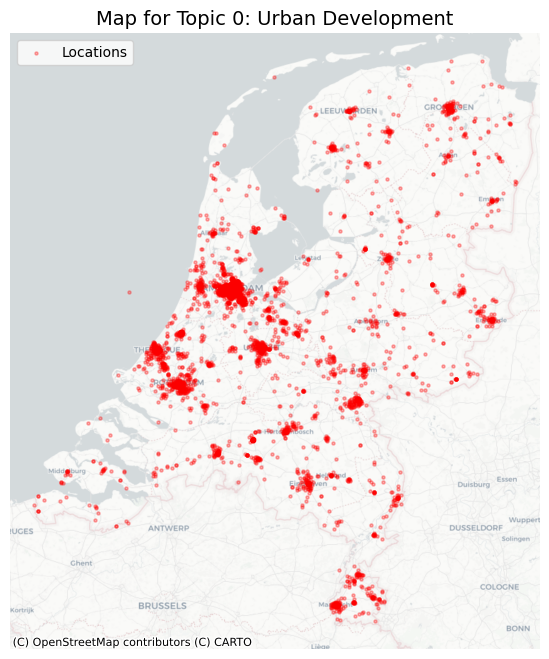

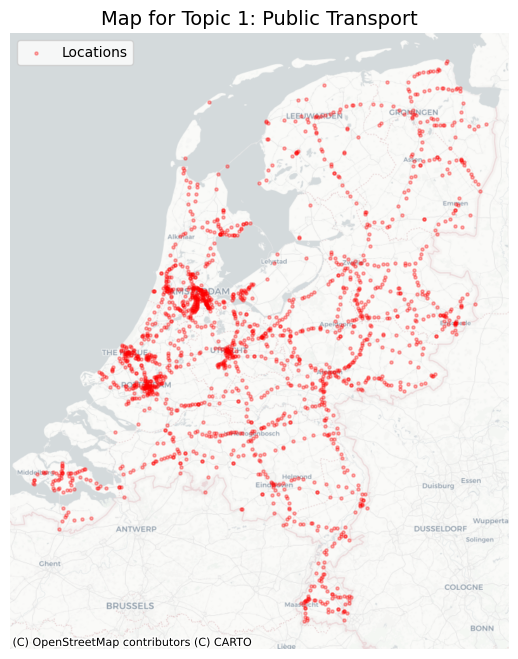

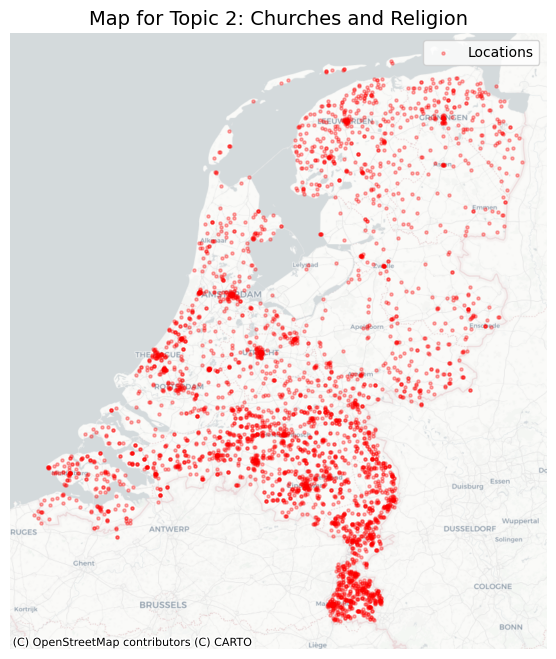

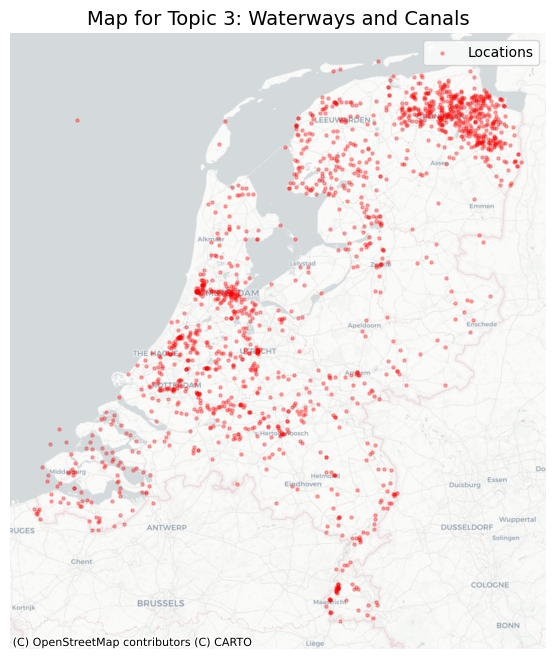

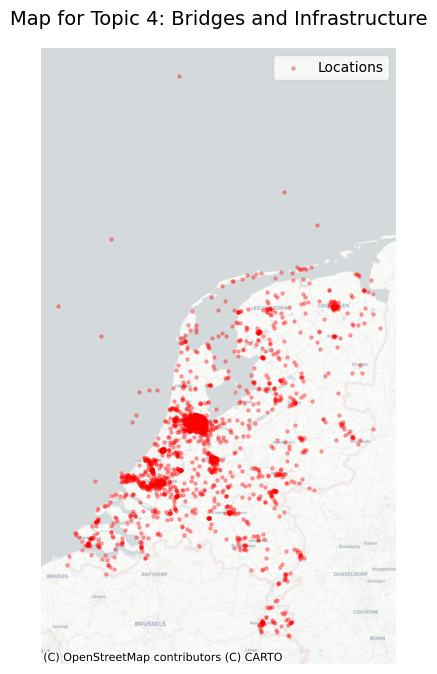

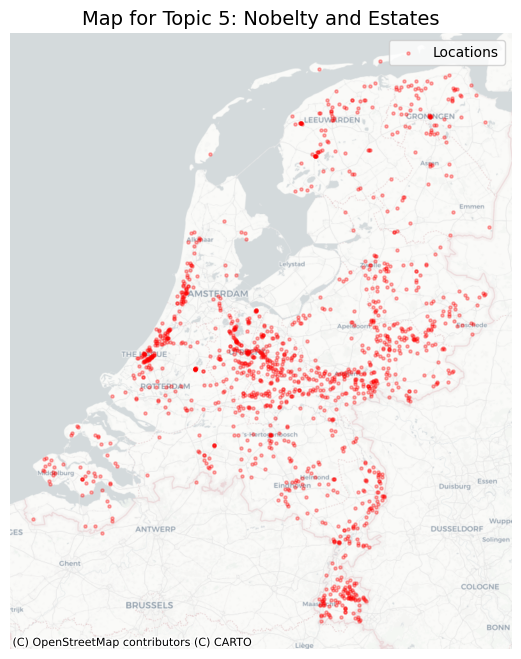

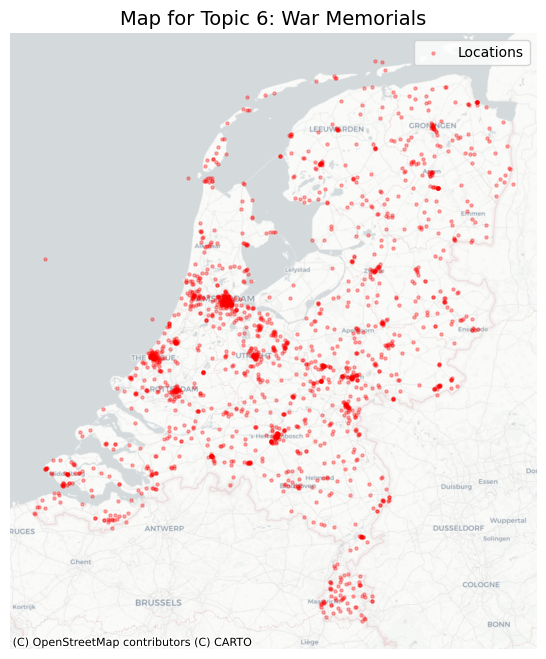

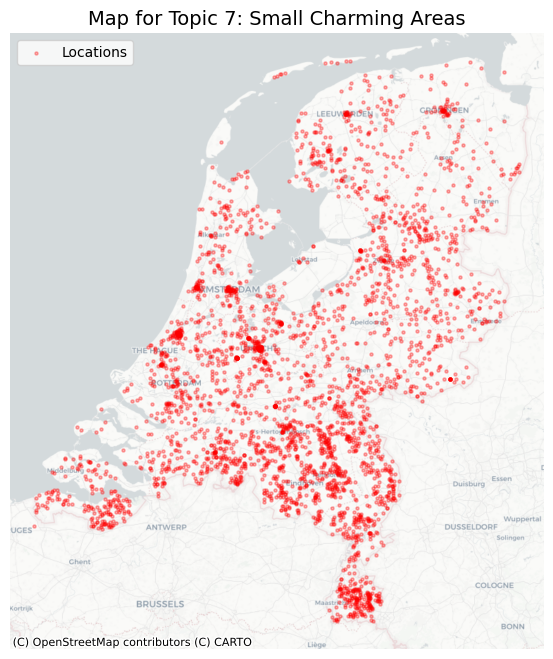

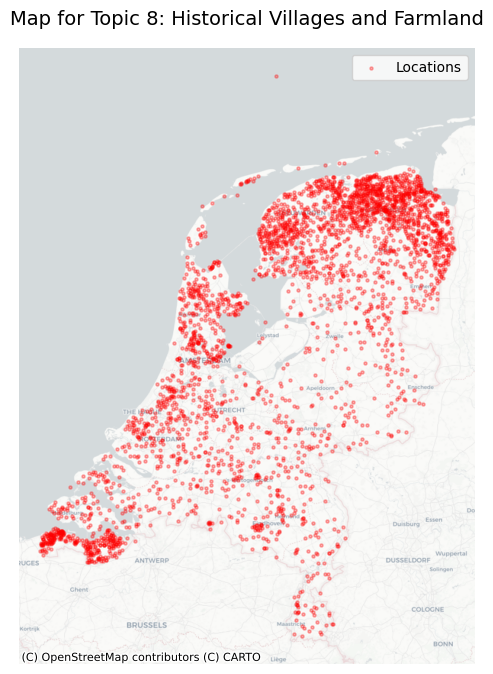

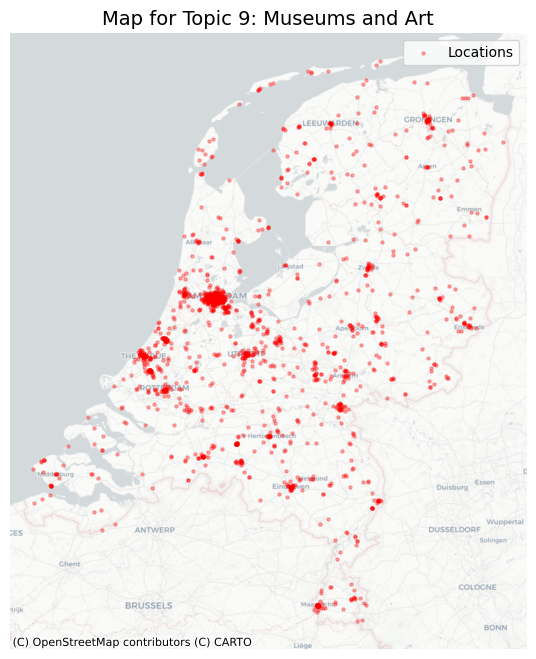

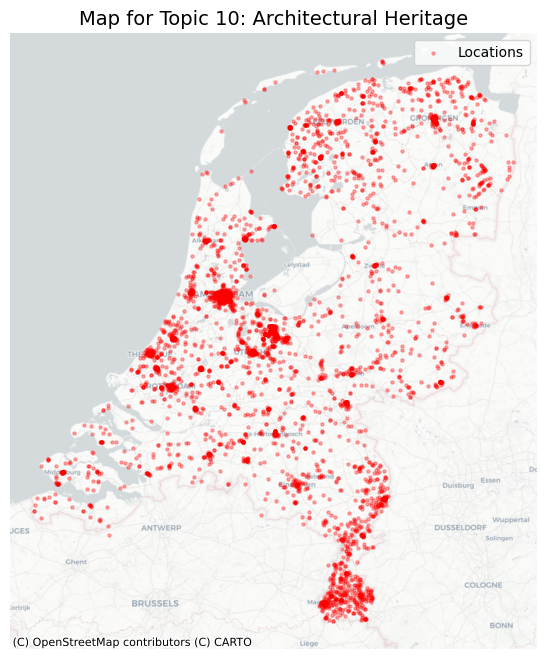

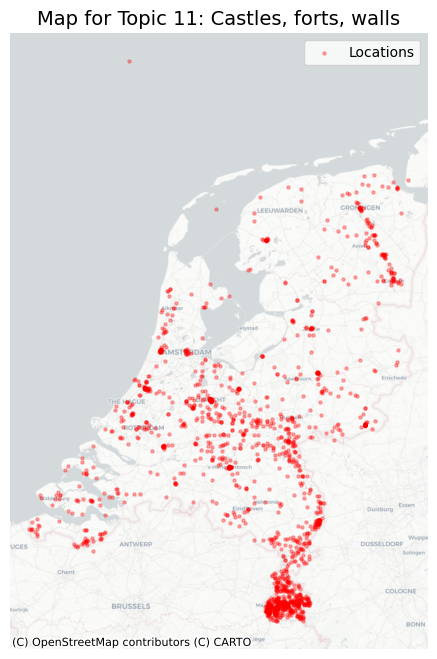

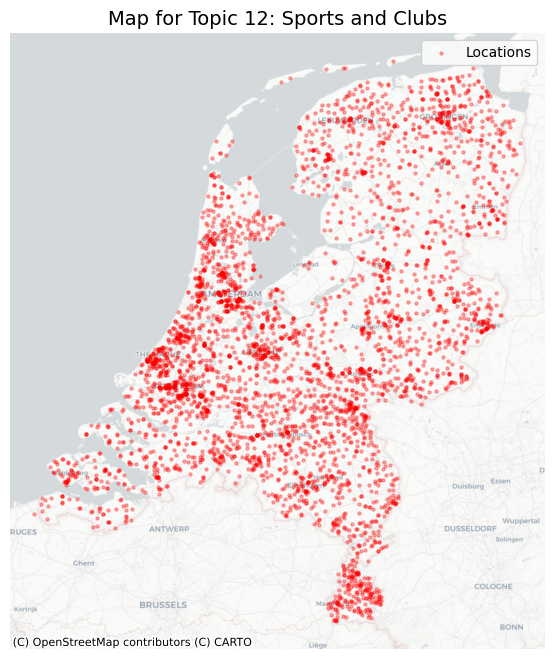

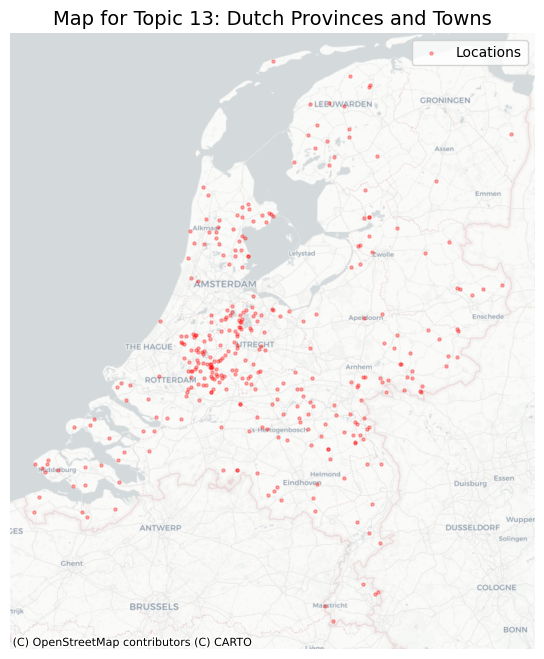

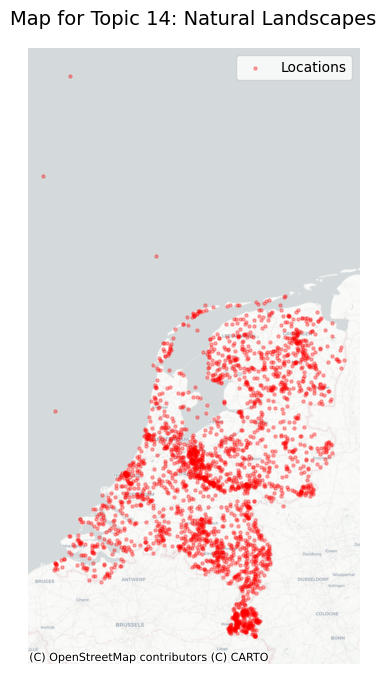

In [84]:
# Ensure your GeoDataFrame has a CRS
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df["longitude"], df["latitude"]))

# Assign a CRS if it doesn't exist (using EPSG:4326 for lat/lon)
if gdf.crs is None:
    gdf.set_crs(epsg=4326, inplace=True)

# Iterate over topics and create maps
for topic_id in range(15):
    # Filter the GeoDataFrame for the current topic
    topic_gdf = gdf[gdf["dominant_topic"] == topic_id]

    # Skip topics with no data
    if topic_gdf.empty:
        print(f"No data for Topic {topic_id}: {topic_names[topic_id]}")
        continue

    # Reproject to Web Mercator (required by contextily)
    topic_gdf = topic_gdf.to_crs(epsg=3857)

    # Create a base map with contextily tiles
    fig, ax = plt.subplots(figsize=(10, 8))
    ax.set_title(f"Map for Topic {topic_id}: {topic_names[topic_id]}", fontsize=14)

    # Plot points as a density map
    topic_gdf.plot(
        ax=ax, 
        markersize=5, 
        alpha=0.3, 
        color="red", 
        label="Locations"
    )

    # Add a valid basemap
    ctx.add_basemap(ax, crs=topic_gdf.crs, source=ctx.providers.CartoDB.Positron)

    # Add labels and a legend
    ax.legend()
    plt.axis("off")
    plt.show()


In [85]:
df['dominant_topic'].value_counts()

dominant_topic
10    5160
0     4881
12    3960
2     3602
7     3318
8     3317
4     3098
14    2557
6     1790
1     1774
11    1751
9     1654
3     1521
5     1383
13     341
Name: count, dtype: int64

: 